# Mass Inference

## Load Model

In [9]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator

#####################################
# Hyperparameters
#####################################
num_points_per_bubble = 24
num_rays_per_point = 6
dim = 2
layers_count = 6
cond_dim = 2 + num_rays_per_point + 1
checkpoint_path = "24022025.pth"

num_samples = 1000
num_density_samples = 20 # default 20
new_size = 512
num_repeats_per_mass = 5 #default 5  
n_masses = 32  # default 32

bubble_id = 2
slice_id = 100

density_path = f"mock_data/halo_density_patches/slice_{slice_id}_bubble_{bubble_id}_halo_density_filtered.npy"
bubble_path = f"mock_data/isolated_bubbles/slice_{slice_id}_bubble_{bubble_id}_isolated.npy"

bubble_data_plt = np.load(bubble_path)

massofdensityreal = np.sum(np.load(density_path))
logmassreal_10 = np.log10(massofdensityreal)
log_mass_real = np.log(massofdensityreal)
logspace_masses = np.logspace(logmassreal_10-1, logmassreal_10+1, n_masses)

In [10]:
class BaseDistribution(nn.Module):
    def __init__(self, mean=torch.tensor([0.0, 0.0]), std=torch.tensor([1.0, 1.0])):
        super().__init__()
        self.dist = torch.distributions.MultivariateNormal(
            loc=mean, covariance_matrix=torch.diag(std**2)
        )

    def sample(self, num_samples):
        return self.dist.sample((num_samples,))

    def log_prob(self, x):
        return self.dist.log_prob(x)

class ActNorm(nn.Module):
    def __init__(self, dim, init=True):
        super().__init__()
        self.dim = dim
        self.initialized = (not init)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.log_scale = nn.Parameter(torch.zeros(dim))

    def initialize_params(self, x):
        with torch.no_grad():
            mean = x.mean(dim=0)
            std = x.std(dim=0)
            self.bias.data = -mean
            self.log_scale.data = torch.log(1.0 / (std + 1e-6))
        self.initialized = True

    def forward(self, x, cond=None):
        if not self.initialized:
            self.initialize_params(x)
        y = (x + self.bias) * torch.exp(self.log_scale)
        log_det = self.log_scale.sum().expand_as(x[:, 0])
        return y, log_det

    def inverse(self, y, cond=None):
        x = y * torch.exp(-self.log_scale) - self.bias
        log_det = -self.log_scale.sum().expand_as(y[:, 0])
        return x, log_det


class Invertible1x1Conv(nn.Module):
    def __init__(self, dim):
        super().__init__()
        w_init = torch.qr(torch.randn(dim, dim))[0]
        self.weight = nn.Parameter(w_init)

    def forward(self, x, cond=None):
        y = x @ self.weight
        log_det = torch.logdet(self.weight).expand_as(x[:, 0])
        return y, log_det

    def inverse(self, y, cond=None):
        W_inv = torch.inverse(self.weight)
        x = y @ W_inv
        log_det = -torch.logdet(self.weight).expand_as(y[:, 0])
        return x, log_det


class AffineCouplingGLOW(nn.Module):
    def __init__(self, dim, cond_dim):
        super().__init__()
        self.dim = dim
        self.half_dim = dim // 2
        self.net = nn.Sequential(
            nn.Linear(self.half_dim + cond_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, self.half_dim * 2),
        )

    def forward(self, x, cond):
        x1 = x[:, :self.half_dim]
        x2 = x[:, self.half_dim:]
        input_net = torch.cat([x1, cond], dim=1)
        s_t = self.net(input_net)
        scale, shift = s_t.chunk(2, dim=1)
        scale = torch.tanh(scale)
        y2 = x2 * torch.exp(scale) + shift
        y = torch.cat([x1, y2], dim=1)
        log_det = scale.sum(dim=1)
        return y, log_det

    def inverse(self, y, cond):
        y1 = y[:, :self.half_dim]
        y2 = y[:, self.half_dim:]
        input_net = torch.cat([y1, cond], dim=1)
        s_t = self.net(input_net)
        scale, shift = s_t.chunk(2, dim=1)
        scale = torch.tanh(scale)
        x2 = (y2 - shift) * torch.exp(-scale)
        x = torch.cat([y1, x2], dim=1)
        log_det = -scale.sum(dim=1)
        return x, log_det


class GLOWStep(nn.Module):
    def __init__(self, dim, cond_dim):
        super().__init__()
        self.actnorm = ActNorm(dim)
        self.inv_conv = Invertible1x1Conv(dim)
        self.coupling = AffineCouplingGLOW(dim, cond_dim)

    def forward(self, x, cond):
        x, ldj_act = self.actnorm(x)
        x, ldj_conv = self.inv_conv(x)
        x, ldj_coup = self.coupling(x, cond)
        return x, (ldj_act + ldj_conv + ldj_coup)

    def inverse(self, y, cond):
        x, ldj_coup = self.coupling.inverse(y, cond)
        x, ldj_conv = self.inv_conv.inverse(x)
        x, ldj_act = self.actnorm.inverse(x)
        return x, (ldj_act + ldj_conv + ldj_coup)


class NormalizingFlow(nn.Module):
    def __init__(self, steps):
        super().__init__()
        self.steps = nn.ModuleList(steps)

    def forward(self, x, cond):
        total_ldj = 0
        for step in self.steps:
            x, ldj = step.forward(x, cond)
            total_ldj += ldj
        return x, total_ldj

    def inverse(self, z, cond):
        total_ldj = 0
        for step in reversed(self.steps):
            z, ldj = step.inverse(z, cond)
            total_ldj += ldj
        return z, total_ldj


class FlowModel(nn.Module):
    def __init__(self, flow, base_dist):
        super().__init__()
        self.flow = flow
        self.base_dist = base_dist

    def forward(self, x, cond):
        z, log_det_jacobian = self.flow.forward(x, cond)
        log_prob = self.base_dist.log_prob(z) + log_det_jacobian
        return log_prob

    def sample(self, num_samples, cond):
        z = self.base_dist.sample(num_samples)
        x, _ = self.flow.inverse(z, cond)
        return x

def sample_points_inside_bubble(bubble_data, num_points):
    indices = np.argwhere(bubble_data > 0)
    if indices.size == 0:
        return np.empty((0, 2))
    chosen_indices = indices[np.random.choice(len(indices), size=num_points, replace=True)]
    offsets = np.random.rand(num_points, 2)
    return chosen_indices + offsets

def compute_ray_lengths(bubble_data, num_rays, start_point):
    sigma = 1
    smoothed = gaussian_filter(bubble_data, sigma=sigma)
    contour_level = 0.3 * np.max(smoothed)
    interp_func = RegularGridInterpolator(
        (np.arange(bubble_data.shape[0]), np.arange(bubble_data.shape[1])),
        smoothed,
        bounds_error=False,
        fill_value=0
    )
    angles = np.deg2rad(np.linspace(0, 360, num_rays, endpoint=False))
    distances = []
    max_distance = np.hypot(*bubble_data.shape)
    sx, sy = start_point
    for angle in angles:
        ray_dx = np.cos(angle)
        ray_dy = np.sin(angle)
        d_vals = np.linspace(0, max_distance, 1000)
        found = False
        for dist_ in d_vals:
            x_ = sx + dist_ * ray_dx
            y_ = sy + dist_ * ray_dy
            if 0 <= x_ < bubble_data.shape[0] and 0 <= y_ < bubble_data.shape[1]:
                val = interp_func((x_, y_))
                if val <= contour_level:
                    distances.append(dist_)
                    found = True
                    break
            else:
                distances.append(dist_)
                found = True
                break
        if not found:
            distances.append(max_distance)
    return np.array(distances)

def create_density_map(samples, grid_shape):
    x_coords = samples[:, 0]
    y_coords = samples[:, 1]
    x_indices = np.clip(np.floor(x_coords).astype(int), 0, grid_shape[1] - 1)
    y_indices = np.clip(np.floor(y_coords).astype(int), 0, grid_shape[0] - 1)
    density_map = np.zeros(grid_shape)
    for x_i, y_i in zip(x_indices, y_indices):
        density_map[y_i, x_i] += 1
    return density_map


flow_steps = [GLOWStep(dim, cond_dim) for _ in range(layers_count)]
flow = NormalizingFlow(flow_steps)
base_dist = BaseDistribution()
model = FlowModel(flow, base_dist)

checkpoint = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

data_x_mean = checkpoint['data_x_mean']
data_x_std = checkpoint['data_x_std']
data_c_mean = checkpoint['data_c_mean']
data_c_std = checkpoint['data_c_std']


## Mass Inference and Density Sampling

Evaluating Log-Likelihood for 32 candidate masses (each averaged over 5 runs).


100%|██████████| 32/32 [26:14<00:00, 49.19s/it]



Best mass (by log-likelihood) ~ 6.203e+12, log-likelihood=-5.5191


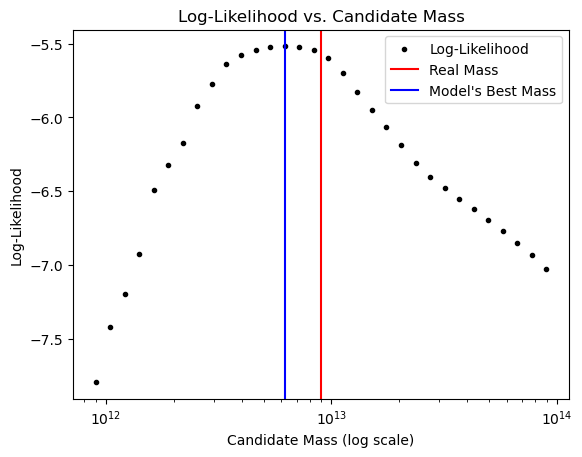

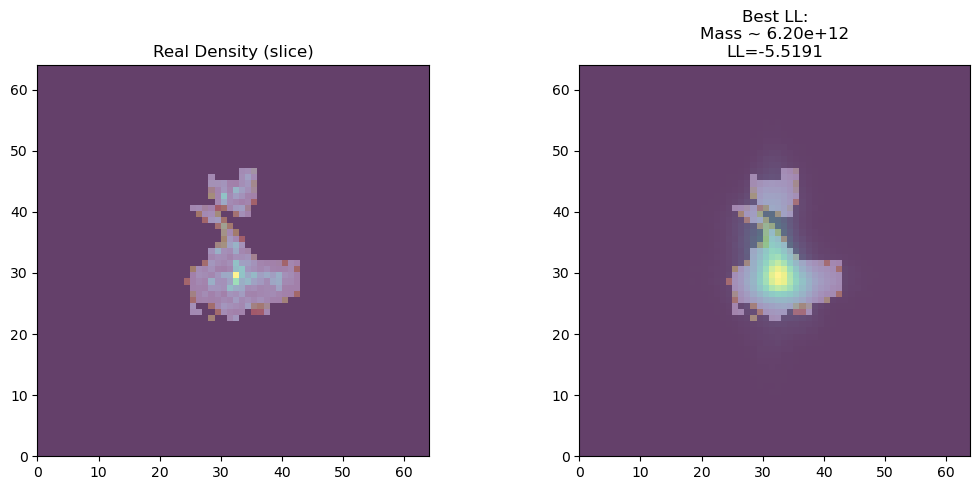

In [11]:
if not os.path.exists(density_path) or not os.path.exists(bubble_path):
    raise FileNotFoundError(f"Could not find data for bubble {bubble_id}.")

density_grid = np.load(density_path)
bubble_data = np.load(bubble_path)

nx, ny = density_grid.shape


valid_points_data = []
attempts = 0
while len(valid_points_data) < num_points_per_bubble and attempts < 1000:
    attempts += 1
    candidate = sample_points_inside_bubble(bubble_data, 1)
    if candidate.size == 0:
        continue
    pt = candidate[0]
    ray_lengths = compute_ray_lengths(bubble_data, num_rays_per_point, pt)
    norm_val = np.linalg.norm(ray_lengths)
    if norm_val == 0 or np.isnan(norm_val):
        continue
    ray_norm = ray_lengths / norm_val
    if np.any(np.isnan(ray_norm)):
        continue
    valid_points_data.append((pt, ray_norm))

if len(valid_points_data) < num_points_per_bubble:
    raise RuntimeError(f"Could not find {num_points_per_bubble} valid centers in bubble {bubble_id}.")

x_ = np.linspace(0, ny - 1, ny)
y_ = np.linspace(0, nx - 1, nx)
Xnew = np.linspace(0, ny - 1, new_size)
Ynew = np.linspace(0, nx - 1, new_size)
grid_x, grid_y = np.meshgrid(Xnew, Ynew)

interp_real = RegularGridInterpolator((y_, x_), density_grid, bounds_error=False, fill_value=0)
fine_real = interp_real((grid_y, grid_x))

smoothed_real = density_grid #or fine_real for interpolation!

def build_modeled_density_map(log_mass_value):
    density_maps = []
    for _ in range(num_density_samples):
        partial_maps = []
        with torch.no_grad():
            for (pt, ray_norm) in valid_points_data:
                cond_vec = np.concatenate([pt, ray_norm, [log_mass_value]])
                cond_vec_norm = (cond_vec - data_c_mean) / data_c_std
                cond_t = torch.tensor(cond_vec_norm, dtype=torch.float32).unsqueeze(0)

                samples = model.sample(num_samples, cond_t.repeat(num_samples, 1))
                samples_np = samples.cpu().numpy()
                # denormalize
                samples_den = samples_np * data_x_std + data_x_mean

                partial_maps.append(create_density_map(samples_den, density_grid.shape))
        # Durchschnitt über alle Center
        density_maps.append(np.mean(partial_maps, axis=0))

    final_map = np.mean(density_maps, axis=0)
    return final_map

def compute_log_likelihood(real_data, model_data):
    sum_real = real_data.sum()
    sum_model = model_data.sum()
    if sum_model <= 0 or sum_real <= 0:
        return -np.inf

    p_real = real_data / sum_real
    p_model = model_data / sum_model

    p_model = np.clip(p_model, 1e-15, None)
    ll = np.sum(p_real * np.log(p_model))
    return ll

log_likelihood_values = []

print(f"Evaluating Log-Likelihood for {n_masses} candidate masses (each averaged over {num_repeats_per_mass} runs).")
for M in tqdm(logspace_masses):
    logM = np.log(M)
    run_lls = []
    for _ in range(num_repeats_per_mass):
        model_map = build_modeled_density_map(logM)
        ll_val = compute_log_likelihood(smoothed_real, model_map)
        if not np.isinf(ll_val) and not np.isnan(ll_val):
            run_lls.append(ll_val)
    if len(run_lls) > 0:
        ll_mean = np.mean(run_lls)
    else:
        ll_mean = -np.inf
    log_likelihood_values.append(ll_mean)

logM_real = np.log(massofdensityreal)
realmass_map = build_modeled_density_map(logM_real)
ll_val_realmass = compute_log_likelihood(smoothed_real, realmass_map)

log_likelihood_values = np.array(log_likelihood_values)

idx_best = np.nanargmax(log_likelihood_values)
best_mass = logspace_masses[idx_best]
best_log_mass = np.log(best_mass)
best_ll = log_likelihood_values[idx_best]

print(f"\nBest mass (by log-likelihood) ~ {best_mass:.4g}, log-likelihood={best_ll:.4f}")

plt.scatter(logspace_masses, log_likelihood_values, label="Log-Likelihood", marker=".", color='k')
plt.axvline(massofdensityreal, color='r', label="Real Mass")
plt.axvline(best_mass, color='b', label="Model's Best Mass")
plt.xscale('log')
plt.xlabel("Candidate Mass (log scale)")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood vs. Candidate Mass")
plt.legend()
plt.show()

best_model_map = build_modeled_density_map(best_log_mass)
real_model_map = build_modeled_density_map(log_mass_real)

fig, axes = plt.subplots(1, 2, figsize=(11, 5))
nx, ny = 64, 64 

axes[0].imshow(bubble_data_plt, origin='lower', cmap='hot', alpha=0.5, extent=(0, ny, 0, nx))
axes[0].imshow(smoothed_real, origin='lower', cmap='viridis', alpha=0.5, extent=(0, ny, 0, nx))
axes[0].set_title("Real Density (slice)")

axes[1].imshow(bubble_data_plt, origin='lower', cmap='hot', alpha=0.5, extent=(0, ny, 0, nx))
axes[1].imshow(best_model_map, origin='lower', cmap='viridis', alpha=0.5, extent=(0, ny, 0, nx))
axes[1].set_title(f"Best LL:\nMass ~ {best_mass:.2e}\nLL={best_ll:.4f}")

plt.tight_layout()
plt.show()

